<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/Random_forest_Modular_Correct(intra_day).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 5.86 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [2]:
!pwd

/content


In [3]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators


In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.1 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
# Import libraries
import os
import sys
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score


In [6]:
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [7]:
tickr ='^nsei'   #'^NSEI' #^NSEBANK  #^cnxit #^GSPC #^YHOH714

STARTDATE='2021-10-15'
ENDDATE='2021-11-15'
START_TESTDATE='2021-11-20'

In [8]:
df_old = pd.DataFrame()

In [9]:
df_old = yf.download(tickr,interval='15m',start=STARTDATE,end=ENDDATE)


[*********************100%***********************]  1 of 1 completed


In [10]:
df_old.shape

(444, 6)

In [11]:
df_old=df_old.reset_index()
df_old.rename(columns={'Datetime':'Date'},inplace=True)
df_old.tail(2)
df_old.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# INPUT

In [12]:
# INPUT .........

#  ********************************* #

t=2
days_out=15


#  ********************************* #

In [13]:
def get_indicators(data ,days_out,t=2):
    data = ta.relative_strength_index(data,days_out)
    #data=ta.exponential_moving_average(data,10*t)
    #data=ta.exponential_moving_average(data,50*t)
    data=ta.momentum(data,7*t)
    data=ta.rate_of_change(data,7*t)
    #data=ta.exponential_moving_average(data,7*t)
    
    #data=ta.exponential_moving_average(data , 10*t)
    #data=ta.exponential_moving_average(data ,20*t)
    #data=ta.force_index(data ,days_out)
    data = ta.on_balance_volume(data , days_out)
    data = ta.standard_deviation(data , days_out)
    data = ta.stochastic_oscillator_d(data ,days_out)
    data = ta.stochastic_oscillator_k(data)
    data = ta.macd(data , 24 , 50)
    #data = ta.ppsr(data)
    #data = ta.trix(data,days_out)
    data = ta.vortex_indicator(data , days_out)
    #data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [14]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

#df_old=df_old.resample('W').last()

In [15]:
train=int(len(df_old)*.75)
df_train= df_old[:train]
df_test= df_old[train+50:]

In [16]:
df_train.shape , df_test.shape

((333, 7), (61, 7))

In [17]:
df_train = get_indicators(df_train,days_out,t)
df_test= get_indicators(df_test,days_out,t)

In [18]:
df_old.tail(2)

,Date,Open,High,Low,Close,Adj Close,Volume
442,2021-11-12 15:00:00+05:30,18104.300781,18115.199219,18088.500000,18096.949219,18096.949219,0
443,2021-11-12 15:15:00+05:30,18096.849609,18112.150391,18093.150391,18098.650391,18098.650391,0


In [19]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

In [20]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [21]:
df_train.columns

Index(['index', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'RSI_15', 'Momentum_14', 'ROC_14', 'OBV_15', 'STD_15', 'SO%d_15',
       'SO%k', 'MACD_24_50', 'MACDsign_24_50', 'MACDdiff_24_50', 'Vortex_15',
       'Signal_Flag'],
      dtype='object')

In [22]:
X_train = df_train.drop(['Open','High','Low','Close','Adj Close','Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Open','High','Low','Close','Adj Close','Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [23]:
############## JUST REMOVE # TO COMPUTE THE BEST PARAMETERS #######################

#rf.best_param_rf(X_train , y_train , 100)

In [24]:
'''
{'Best Score': 0.9625346964575261,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 20,
  'max_features': 'log2',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 2,
  'min_samples_split': 40,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 600,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n{'Best Score': 0.9625346964575261,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 20,\n  'max_features': 'log2',\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 2,\n  'min_samples_split': 40,\n  'min_weight_fraction_leaf': 0.0,\n  'n_estimators': 600,\n  'n_jobs': None,\n  'oob_score': False,\n  'random_state': None,\n  'verbose': 0,\n  'warm_start': False}}\n  "

In [25]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 600,max_depth=20,min_samples_leaf=2,class_weight=None,max_features='log2',min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)
# class_weight={-1:1.25,1:1},

In [26]:
y_train.value_counts()

-1.0    145
 1.0    131
Name: Signal_Flag, dtype: int64

In [27]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', f1_score(y_test, rand_frst_clf.predict(X_test), average='macro') * 100.0)

Correct Prediction RForest (%):  100.0


In [28]:
#cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [29]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

# Logistic Regression

In [30]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [31]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [32]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', f1_score(y_test, LogReg.predict(X_test), average='macro') * 100.0)

Correct Prediction Logistic Regression (%):  100.0


In [33]:
#cm.confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [34]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [35]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', f1_score(y_test, svc_classifier.predict(X_test), average='macro') * 100.0)

Correct Prediction Logistic Regression (%):  100.0


In [36]:
#cm.confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [37]:
import xgboost as xgb

In [38]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=2,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=2,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [39]:
'''
({'colsample_bytree': 0.75,
  'gamma': 0.0,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 100,
  'reg_alpha': 0.01,
  'subsample': 0.75},
 0.9968901441330651)
'''

"\n({'colsample_bytree': 0.75,\n  'gamma': 0.0,\n  'learning_rate': 0.1,\n  'max_depth': 3,\n  'min_child_weight': 1,\n  'n_estimators': 100,\n  'reg_alpha': 0.01,\n  'subsample': 0.75},\n 0.9968901441330651)\n"

In [40]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (f1_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 100.00


In [41]:
#cm.confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

In [42]:
feature_imp_XGB = pd.Series(xgb_classifier.feature_importances_, index=feats).sort_values(ascending=False)
feature_imp_XGB*100

Momentum_14       39.587887
Vortex_15         24.826975
RSI_15             7.954902
ROC_14             4.866490
index              3.984627
MACDdiff_24_50     3.841070
SO%d_15            3.530371
STD_15             3.524923
SO%k               3.388236
MACDsign_24_50     2.637197
MACD_24_50         1.857324
OBV_15             0.000000
Volume             0.000000
dtype: float32

In [43]:
features = {'Random Forest' : feature_imp,'XGBoost': feature_imp_XGB}
feats=pd.DataFrame(features)

In [44]:
feats.sort_values(by=['XGBoost'],ascending=False)

,Random Forest,XGBoost
Momentum_14,0.254989,0.395879
Vortex_15,0.216508,0.248270
RSI_15,0.110443,0.079549
ROC_14,0.187418,0.048665
index,0.012155,0.039846
MACDdiff_24_50,0.116048,0.038411
SO%d_15,0.059477,0.035304
STD_15,0.005444,0.035249
SO%k,0.005109,0.033882
MACDsign_24_50,0.009701,0.026372


# Make Actual Prediction

In [45]:
df = pd.DataFrame()

In [46]:
df = yf.download(tickr,interval='15m',start=START_TESTDATE)

[*********************100%***********************]  1 of 1 completed


In [47]:
df=df.reset_index()
df.rename(columns={'Datetime':'Date'},inplace=True)
df.tail(2)
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# Check This For Weekly or Daily

In [48]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
#df=df.resample('W').last()

In [49]:
df = get_indicators(df,days_out,t)
#df= impulse(df)

In [50]:
df.tail(2)

,index,Open,High,Low,Close,Adj Close,Volume,RSI_15,Momentum_14,ROC_14,OBV_15,STD_15,SO%d_15,SO%k,MACD_24_50,MACDsign_24_50,MACDdiff_24_50,Vortex_15
Date,,,,,,,,,,,,,,,,,,
2021-12-08 15:15:00+05:30,324,17472.449219,17474.300781,17459.050781,17467.849609,17467.849609,0,0.739921,45.048828,0.002591,0.0,20.039976,0.618915,0.576972,73.763263,72.388123,1.37514,0.311439
2021-12-08 15:30:00+05:30,325,17469.750000,17469.750000,17469.750000,17469.750000,17469.750000,0,0.739921,47.050781,0.002902,0.0,20.140759,0.618915,NaN,73.386099,72.587718,0.79838,0.372703


In [51]:
df_old.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-18 11:45:00+05:30,18503.849609,18509.800781,18500.599609,18500.949219,18500.949219,0
1,2021-10-18 12:00:00+05:30,18500.949219,18521.849609,18494.150391,18514.699219,18514.699219,0


In [52]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

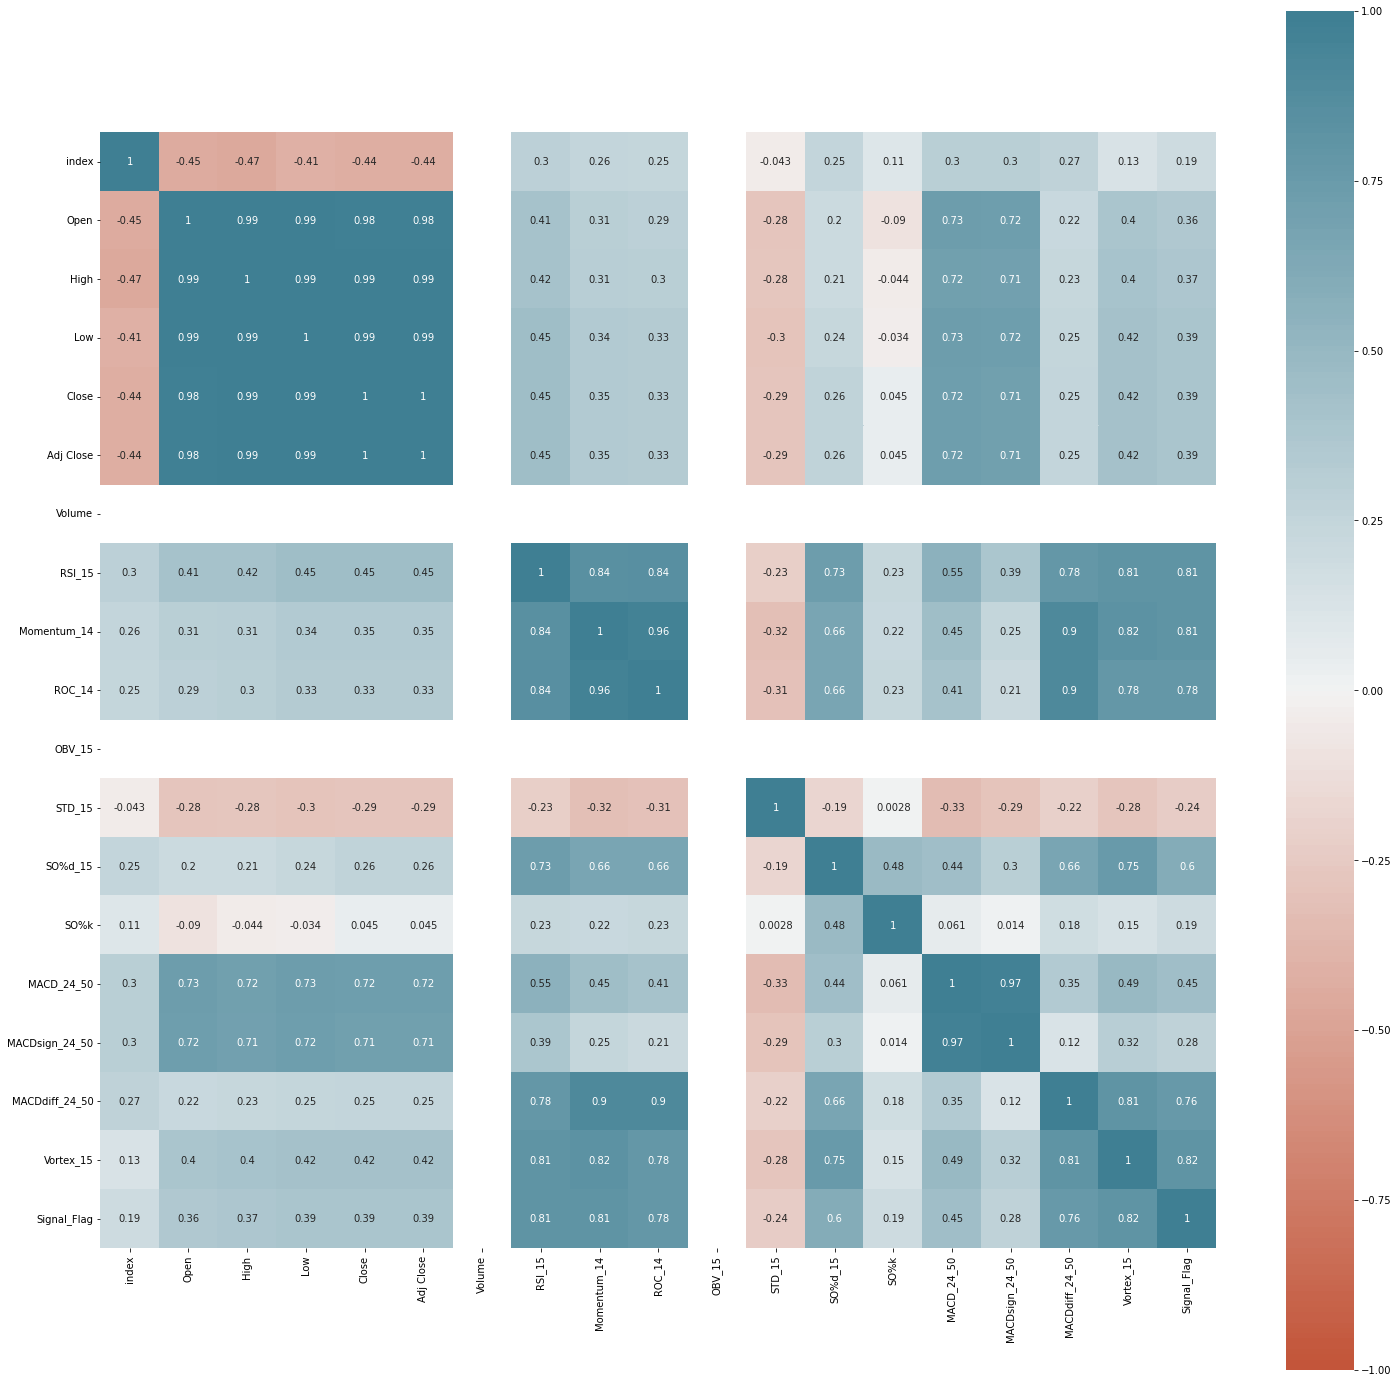

In [53]:
ta.correlation_map(df,25)

In [54]:
df.shape

(326, 19)

In [55]:
df=df.dropna()

In [56]:
df.shape

(268, 19)

In [57]:
new_data = df.drop(['Open','High','Low','Close','Adj Close','Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [58]:
model='random_forest'

In [59]:
preds=rf.make_preds(new_data ,rand_frst_clf,model,df)

In [60]:
print("days_out : ",days_out)

days_out :  15


In [61]:
preds.head(2)

,predsrandom_forest
Date,
2021-11-24 11:00:00+05:30,1.0
2021-11-24 11:15:00+05:30,1.0


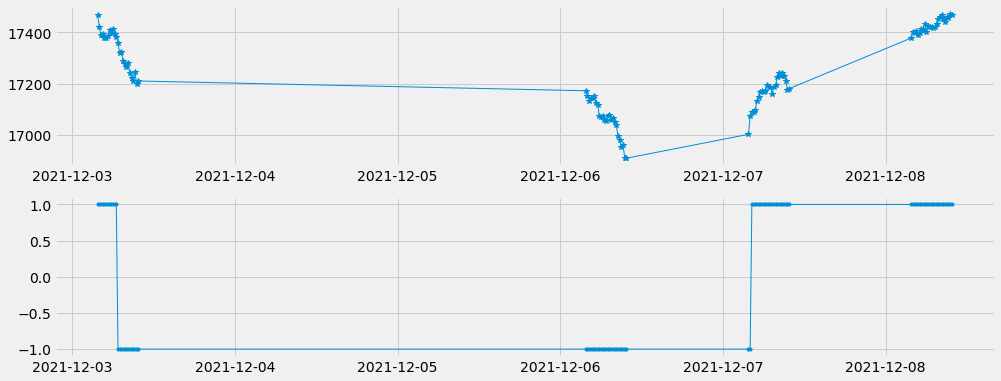

In [62]:
linplt.lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100

In [63]:
pred = pd.DataFrame(rf.make_preds(new_data , rand_frst_clf, model,df))

In [64]:
pred.head(2)

,predsrandom_forest
Date,
2021-11-24 11:00:00+05:30,1.0
2021-11-24 11:15:00+05:30,1.0


In [65]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [66]:
l= len(pred)

In [67]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [68]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [69]:
model='_XGB'

In [70]:
predX=rf.make_preds(new_data.values ,xgb_classifier,model,df)

In [71]:
predX= pd.concat([predX ,df.Close],axis=1)

In [72]:
predX.head(2)

,preds_XGB,Close
Date,,
2021-11-24 11:00:00+05:30,1.0,17590.550781
2021-11-24 11:15:00+05:30,1.0,17570.800781


In [73]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

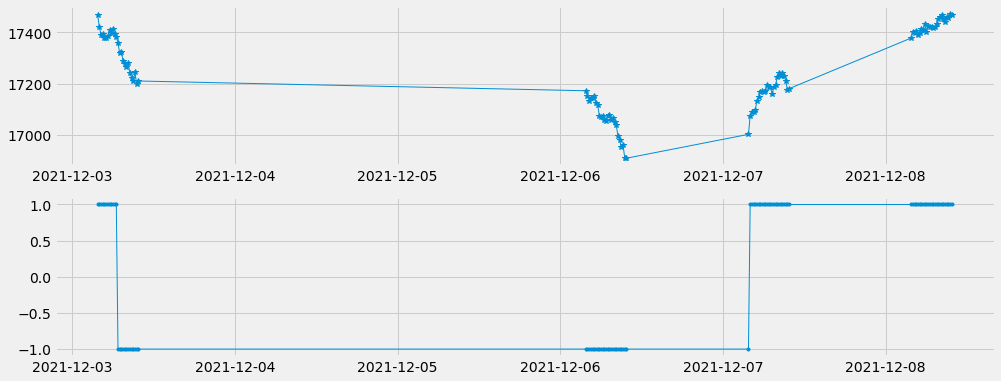

In [74]:
linplt.lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [75]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [76]:
model='_Logistic_Regression'

In [77]:
preds_logreg=pd.DataFrame(rf.make_preds(new_data , LogReg,model, df))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [78]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
2021-11-24 11:00:00+05:30,1.0
2021-11-24 11:15:00+05:30,1.0


In [79]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [80]:
predL=predL.reset_index()

In [81]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

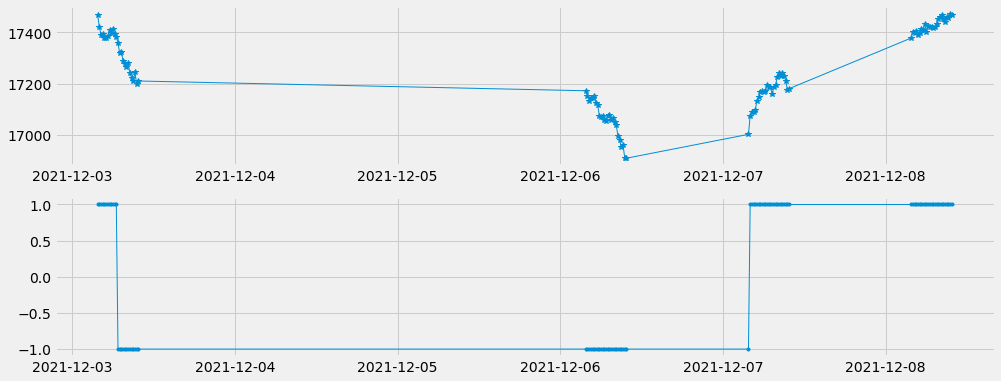

In [82]:
linplt.lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [83]:
model='_SVC'

In [ ]:
preds_svc=pd.DataFrame(rf.make_preds(new_data ,svc_classifier,model, df))

In [85]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [86]:
predS=predS.reset_index()

In [87]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

In [88]:
df=df.reset_index()

In [92]:
predS.columns

Index(['Date', 'preds_SVC', 'Close', 'Buy_ind_SVC', 'Sell_ind_SVC'], dtype='object')

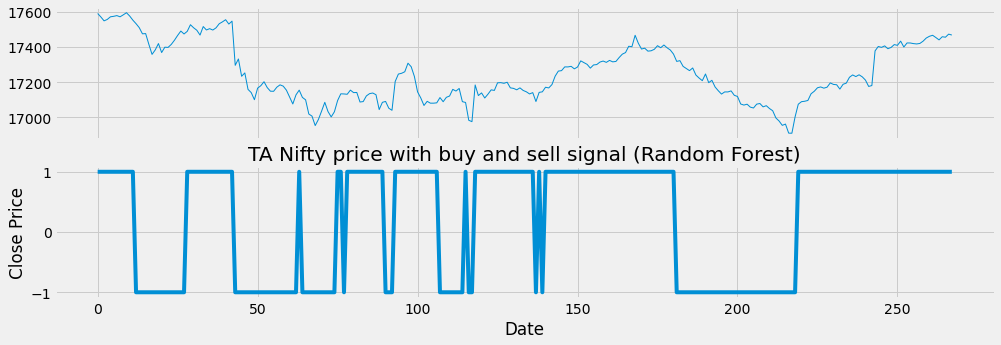

In [102]:
fig, ax = plt.subplots(2,1,figsize=(15,5),linewidth=1,sharex=True)
ax[0].plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)

ax[1].plot(predS['preds_SVC'])

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (SVC)') 

plt.savefig('a.png')
plt.show();

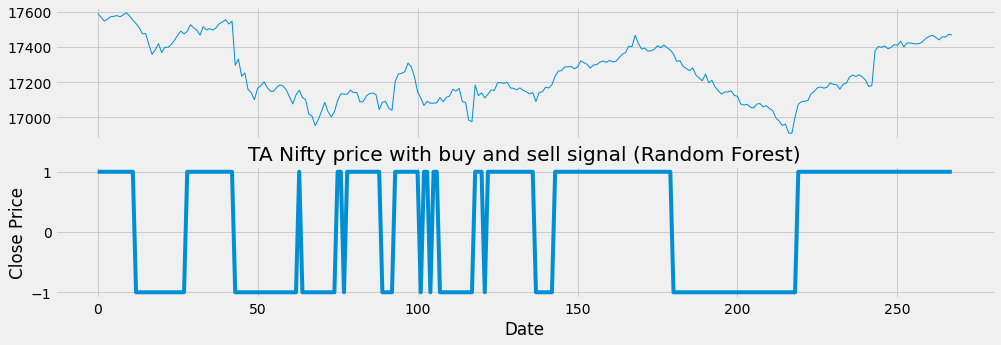

In [103]:
fig, ax = plt.subplots(2,1,figsize=(15,5),linewidth=1,sharex=True)
ax[0].plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)

ax[1].plot(predX['preds_XGB'])

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XG Boost)') 

plt.savefig('a.png')
plt.show();

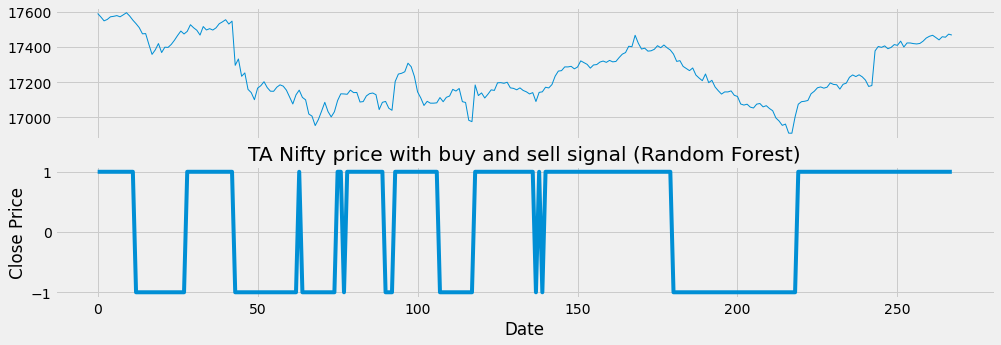

In [104]:
fig, ax = plt.subplots(2,1,figsize=(15,5),linewidth=1,sharex=True)
ax[0].plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)

ax[1].plot(predL['preds_Logistic_Regression'])

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

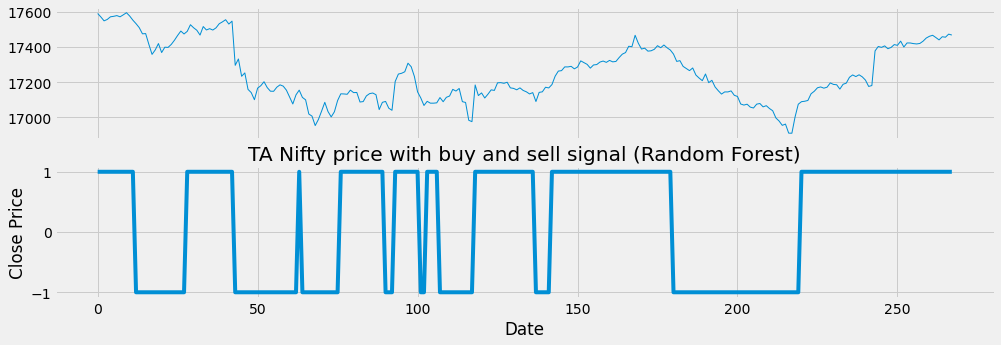

In [105]:
fig, ax = plt.subplots(2,1,figsize=(15,5),linewidth=1,sharex=True)
ax[0].plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)

ax[1].plot(pred['predsrandom_forest'])

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

In [106]:
pred['ensemble'] = pred['predsrandom_forest']*1+predL['preds_Logistic_Regression']*0.5+predS['preds_SVC']*0.5+predX['preds_XGB']*1

In [108]:
pred.ensemble=np.where(pred['ensemble']>-2,1,0)

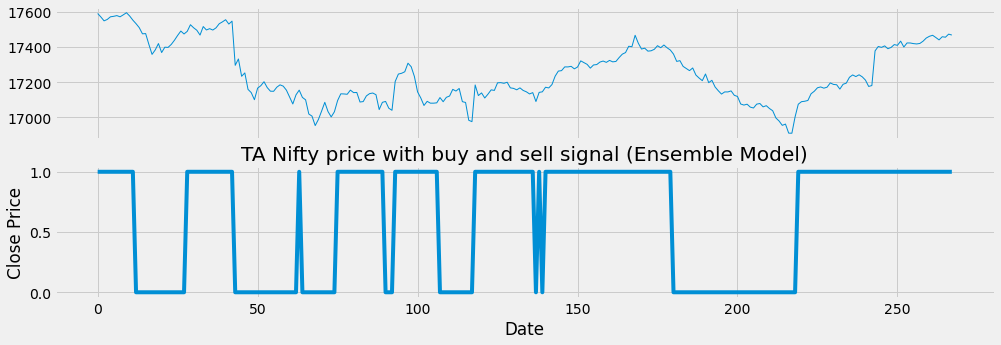

In [109]:
fig, ax = plt.subplots(2,1,figsize=(15,5),linewidth=1,sharex=True)
ax[0].plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)

ax[1].plot(pred['ensemble'])

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Ensemble Model)') 

plt.savefig('a.png')
plt.show();

In [ ]:
linplt.lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=450) # no_of_datapoints=100

In [ ]:
#pred['Signal_from_close']=np.where((pred.Close>pred.Close.shift(1)),1,0)

In [ ]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>=0), 1, 0)
pred['Sell_ensemble'] = np.where((pred['ensemble']<0), 0, 1)
#pred['Neutral'] = np.where((pred['ensemble']==-0.5),0,1)
pred['signal4theday']= np.where((pred['ensemble']>0),1,0)

In [ ]:
pred['signalF']=pred['signal4theday']

In [ ]:
pred.to_csv('rf_ta.csv')

In [ ]:
def plot_me_buy_sell_signal(pred,small_period,large_period):
  buy=[]
  sell=[]
  for i in range(len(pred)):
    if pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i]>pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i] and \
    pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i-1]<pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i-1]:
      buy.append(i)
    elif pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i]<pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i] and \
    pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i-1]>pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i-1]:
      sell.append(i)
  
  return buy,sell

In [ ]:
buy,sell=plot_me_buy_sell_signal(pred,10,30)

In [ ]:
plt.figure(figsize=(28,16))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='Up', color='green', s=35, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==0 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==0, 'Close'].values, label='Down', color='red', s=35, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=3,color='y',label='Buy')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='*',s=3,color='r',label='Sell')
#plt.plot(df.index,df['EMA_50'].values[-l:],label='EMA 50')
#plt.plot(df.index,df['EMA_10'].values[-l:], label='EMA 10')

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price') 
plt.legend(loc='upper left') 
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

In [ ]:
cm.confus_matrix(df.Signal_Flag,preds,rand_frst_clf,new_data,actuals,plot=True )


In [ ]:
#cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True, test=False)


In [ ]:
# saving the dataframe
pred[['Date','signalF','Close']].to_csv('/content/rf_TA.csv')

In [ ]:
pred.head(1)

In [ ]:
pred.set_index('Date',inplace=True)

In [ ]:
pred.tail(2)

In [ ]:
pred['actual']=np.where(pred.Close>pred.Close.shift(1),1,0)
pred['dummy']= np.where(pred.signal4theday==0,0,1)
pred['dummyS']=pred['dummy'].shift(1)
pred=pred.dropna()

In [ ]:
pred.signalF.value_counts()

In [ ]:
print(f"Class 0 has {round(pred.dummyS.value_counts()[0]/(pred.dummyS.value_counts()[0]+pred.dummyS.value_counts()[1])*100)}% samples")

In [ ]:
print(f"Class 1 has {round(pred.dummyS.value_counts()[1]/(pred.dummyS.value_counts()[0]+pred.dummyS.value_counts()[1])*100)}% samples")

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(pred.actual, pred.dummyS)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]
from sklearn.metrics import average_precision_score,f1_score
average_precision = average_precision_score(pred.actual, pred.dummyS)
f1=f1_score(pred.actual, pred.dummyS,average=None)
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))
print(f'f1 score class wise for down : {round(f1[0]*100)}.00% ,up : {round(f1[1]*100)}.00%')
accuracy_pos = (true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
accuracy_neg = (true_negatives) / (true_negatives + true_positives + false_negatives + false_positives)
print('Accuracy positive: {}'.format(float(accuracy_pos)))
print('Accuracy negative {}'.format(float(accuracy_neg)))

In [ ]:
y_true = pred.actual
y_pred = pred.dummyS
target_names = ['class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_Return'] = pred.Return * pred.dummy.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_Return+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()

In [ ]:
!pip install mplfinance

In [ ]:
pred['signalF'].plot()